# Installs and Imports

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Standard Imports
import os
import sys
import random
import time
import math
import joblib
from tqdm import tqdm
import re
import string
import json

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm.keras import TqdmCallback
import tensorflow.keras.backend as K

# NLTK
import nltk
from nltk.tokenize import word_tokenize

# Google Colab-Specifc Imports
from google.colab import drive
drive.mount('/content/drive')

# Configure Notebook and Styles
%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

# Set Random Seeds
os.environ['PYTHONHASHSEED'] = str(123)
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Mounted at /content/drive


# Loading the Data

In [ ]:
# Path to the data
data_path = '/content/drive/My Drive/Datasets/amazon_reviews_cleaned.csv'

# Read in the data
df = pd.read_csv(data_path, parse_dates=['Date'])

In [ ]:
# View the dataset
df.head()

,ProductId,UserId,ProfileName,Date,Summary,Text,Score,HelpfulnessNumerator,HelpfulnessDenominator,Time,Helpfulness,WeightedHelpfulness
0,B000O160KE,A1P9NJ7JQZRHCT,Professor X,2009-11-29,Sweet & Low without the cancer.,"If you like the (bitter) taste of Sweet & Low,...",1,0,1,1259452800,0.0,0.000000
1,B004NB79VU,ACP87CNOMX1DJ,"Tanya L. Ouzts ""wedding mom""",2012-05-21,wedding mom,item was much smaller than appeared on line. ...,1,0,0,1337558400,0.0,0.000000
2,B003VXHGPK,A25UTJ1AXFC0Z9,Judy Armstrong,2011-12-09,Don't waste your money or your Keurig on this!,This coffee tastes very flavorful and is not t...,1,1,2,1323388800,0.5,0.549306
3,B0030FGMFY,A2JER2JSWJG5VL,Jaybee,2011-08-20,MADE IN CHINA!!!,I bought these for my Dalmatian for the first ...,1,4,5,1313798400,0.8,1.433408
4,B004S04X4W,AY1EF0GOH80EK,Natasha Stryker,2011-12-19,Tastes like cheap meat and salt,"I guess I am in the minority, but this hash pr...",1,3,6,1324252800,0.5,0.972955


# Creating the Labels

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

# Load tokenizer and model
MODEL = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Define a custom dataset class
class TextDataset(Dataset):
  def __init__(self, texts):
    self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings['input_ids'])

# Prepare the dataset
texts = df['Text'].tolist()
dataset = TextDataset(texts)

In [ ]:
!pip install transformers[torch] accelerate -U -q

In [ ]:
import transformers
import accelerate

print(f'Transformers version: {transformers.__version__}')
print(f'Accelerate version: {accelerate.__version__}')

Transformers version: 4.35.2
Accelerate version: 0.25.0


In [ ]:
# Setup training arguments without actually training
training_args = TrainingArguments(
    output_dir='./results',
    do_train=False,                  # No training (only predicting)
    do_predict=True,
    per_device_eval_batch_size=64,   # Batch size for evaluation
    dataloader_drop_last=False       # Drop last incomplete batch if not divisible by batch size
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
)

In [ ]:
# Make predictions
predictions = trainer.predict(dataset)
predictions = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1)

# Decode predictions
sentiments = ['negative', 'neutral', 'positive']
df['Sentiment'] = [sentiments[pred.argmax()] for pred in predictions]

# View DataFrame results
df[['Text', 'Sentiment']]

,Text,Sentiment
0,"If you like the (bitter) taste of Sweet & Low,...",positive
1,item was much smaller than appeared on line. ...,neutral
2,This coffee tastes very flavorful and is not t...,negative
3,I bought these for my Dalmatian for the first ...,positive
4,"I guess I am in the minority, but this hash pr...",neutral
...,...,...
56836,I use to buy this at PetSmart...they no longer...,positive
56837,I love these tasty snacks. They have a great ...,positive
56838,I ordered the dog treats and they were here wi...,positive
56839,My teens and their friends drink regular soda ...,positive


In [ ]:
# Save the DataFrame with the new labels
df.to_csv('/content/drive/My Drive/Datasets/amazon_reviews_cleaned_with_labels.csv', index=False)

In [2]:
# Load the Dataframe
df = pd.read_csv('/content/drive/My Drive/Datasets/amazon_reviews_cleaned_with_labels.csv', parse_dates=['Date'])

In [3]:
# Sample 5 positive reviews and print them
print("Sample positive reviews:")
for review in df[df['Sentiment'] == 'positive'].sample(5)['Text']:
    print(review)
    print("\n")

# Sample 5 neutral reviews and print them
print("Sample neutral reviews:")
for review in df[df['Sentiment'] == 'neutral'].sample(5)['Text']:
    print(review)
    print("\n")

# Sample 5 negative reviews and print them
print("Sample negative reviews:")
for review in df[df['Sentiment'] == 'negative'].sample(5)['Text']:
    print(review)
    print("\n")

Sample positive reviews:
I like one of the bend in the mix (the KONA bend).  It is unexpected good.  The other bends are OK.  But this is just my personal preference,


I started him off on the Puffs, since I was a little afraid of the Crunchies because they looked so big. But he actually has a lot easier time with these. They seem to dissolve a little better than the Puffs, and since they are bigger he can manipulate them better. He either holds them while he noms on one end (they dissolve fast), or he's able to push it around in his mouth well enough that he doesn't gag. The Puffs tend to go to the back of his tongue and he often coughs and gags on them. They are nutritious, and there may be better snacks out there but for right now these are awesome.


Copper Moon Costa Rican coffee is a very full flavored coffee and not at all acidic. It is a medium roast just as described.  I would highly recommend it to anyone who enjoys a good cup of coffee that you can honestly taste.  The only

In [4]:
# Display 5-star reviews that were labeled as 'negative'
negative_five_star_reviews = df[(df['Score'] == 5) & (df['Sentiment'] == 'negative')]['Text'].sample(5)
print("\n5-star reviews labeled as negative:")
for review in negative_five_star_reviews:
    print(f"\n{review}")

# Add extra newline for better readability
print("\n")

# Display 1-star reviews that were labeled as 'positive'
positive_one_star_reviews = df[(df['Score'] == 1) & (df['Sentiment'] == 'positive')]['Text'].sample(5)
print("\n1-star reviews labeled as positive:")
for review in positive_one_star_reviews:
    print(f"\n{review}")


5-star reviews labeled as negative:

Unlike microwave popcorn, you cannot hear the pork skins cooking, so only by trial and error and the wattage of your microwave will you know how long to cook these. Cooked to the proper timing, they will be fluffy, melt in you mouth. 15 seconds too long you will have a stinky unedible product.<br />It is something that you must try. I cooked mine for 1 minute 45 seconds and they were not all done. I do not know the wattage of my microwave.<br />So try them for your self. As I said, they are different than popcorn, but have the same results if left too long in the micowave, stinky.

What can I say...this is the only brand of food my cat will eat. She tears into the bag by chewing on it as soon as I get it. I have to pour in into a plastic container. It also controls hair balls.

i just tried 2 bottles so far. my first i took halves and lasted 10+ hours. i waited near 72 hour mark before drinking the last half and it was really weak. my guess w/e is 

# Preprocessing the Data

## Split the Data

In [5]:
from sklearn.model_selection import train_test_split

# Convert labels to integers
df['Sentiment'] = df['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Define the X and y variables
X = df['Text']
y = df['Sentiment']

# Split the data into training, validation, and test sets (70/15/15)
initial_test_size = 0.15

# First split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=initial_test_size, stratify=y, random_state=42
)

# Calculate the remaining proportion
remaining_size = len(X_train_val) / len(df['Text'])
val_prop_remaining = 0.15 / remaining_size

# Second split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_prop_remaining,
    stratify=y_train_val, random_state=42
)

# Verify the sizes of each set
print("Training set size:", len(X_train) / len(df['Text']))
print("Validation set size:", len(X_val) / len(df['Text']))
print("Test set size:", len(X_test) / len(df['Text']))

Training set size: 0.6999700920110483
Validation set size: 0.1500149539944758
Test set size: 0.1500149539944758


In [6]:
# Calculate and print the proportions of each sentiment label in each dataset
train_label_proportions = y_train.value_counts(normalize=True)
val_label_proportions = y_val.value_counts(normalize=True)
test_label_proportions = y_test.value_counts(normalize=True)

print(f"Training set label proportions:\n{train_label_proportions}")
print(f"\nValidation set label proportions:\n{val_label_proportions}")
print(f"\nTest set label proportions:\n{test_label_proportions}")

Training set label proportions:
2    0.772313
0    0.154850
1    0.072838
Name: Sentiment, dtype: float64

Validation set label proportions:
2    0.772370
0    0.154802
1    0.072827
Name: Sentiment, dtype: float64

Test set label proportions:
2    0.772370
0    0.154802
1    0.072827
Name: Sentiment, dtype: float64


## Text Vectorization Layer

In [7]:
# Tokenize the text
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['Text'])

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['Text'])

# Calculate the length of each sequence
sequence_lengths = [len(sequence) for sequence in sequences]

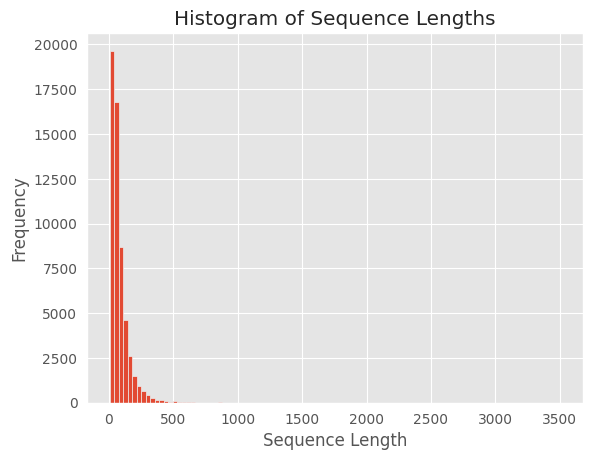

In [8]:
# Plot histogram of sequence lengths
plt.hist(sequence_lengths, bins=100)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Histogram of Sequence Lengths");

In [9]:
# Define custom standardization function
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br >', ' ')
  stripped_punctuation = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
  return stripped_punctuation

# Define the vocabulary size and number of words in a sequence
vocab_size = len(tokenizer.word_index) + 1
sequence_length = 500

# Create the TextVectorization layer
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Fit the vectorize layer to the training set
vectorize_layer.adapt(X_train)

## TensorFlow Datasets

In [10]:
# Convert the vectorized data into TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Define a function to apply vectorization
def vectorize_text(text, label):
    text = vectorize_layer(text)
    return text, label

# Apply vectorization using the map function
train_dataset = train_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(vectorize_text, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
# Cache, batch, and prefetch for performance
batch_size = 32

train_dataset = train_dataset.cache() \
                             .shuffle(buffer_size=len(X_train)) \
                             .batch(batch_size, drop_remainder=True) \
                             .prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.cache() \
                         .batch(batch_size, drop_remainder=True) \
                         .prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.cache() \
                           .batch(batch_size, drop_remainder=True) \
                           .prefetch(tf.data.AUTOTUNE)

In [12]:
# Check the features and labels
for features, label in train_dataset.take(1):
    print("Features:", features)
    print("Label:", label)

Features: tf.Tensor(
[[   3   21 1625 ...    0    0    0]
 [   3   68  124 ...    0    0    0]
 [   3  995   14 ...    0    0    0]
 ...
 [  13 2089  107 ...    0    0    0]
 [  37  181  465 ...    0    0    0]
 [  38  143  598 ...    0    0    0]], shape=(32, 500), dtype=int64)
Label: tf.Tensor([2 1 0 2 2 2 2 0 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 2 2], shape=(32,), dtype=int64)


In [13]:
# Check the shapes
for features, labels in train_dataset.take(1):
    print("Feature batch shape:", features.shape)
    print("Label batch shape:", labels.shape)

Feature batch shape: (32, 500)
Label batch shape: (32,)


# Building the Models

## Transformer

In [14]:
# Positional Embedding Layer
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [15]:
# Transformer Block Layer
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Set the parameters
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 128
num_heads = 4
ff_dim = 2 * embed_dim
maxlen = sequence_length
num_classes = df['Sentiment'].nunique()
dropout_rate = 0.1
num_layers = 4
num_epochs = 10

In [ ]:
# Input Layer
inputs = tf.keras.layers.Input(shape=(maxlen,))

# Embedding Layer
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)

# Transformer Blocks
for _ in range(num_layers):
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x)

# Global Average Pooling
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(20, activation='relu')(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)

# Output Layer
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 128)          6179328   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 500, 128)          330240    
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  (None, 500, 128)          330240    
 formerBlock)                                                    
                                                                 
 transformer_block_2 (Trans  (None, 500, 128)          330240

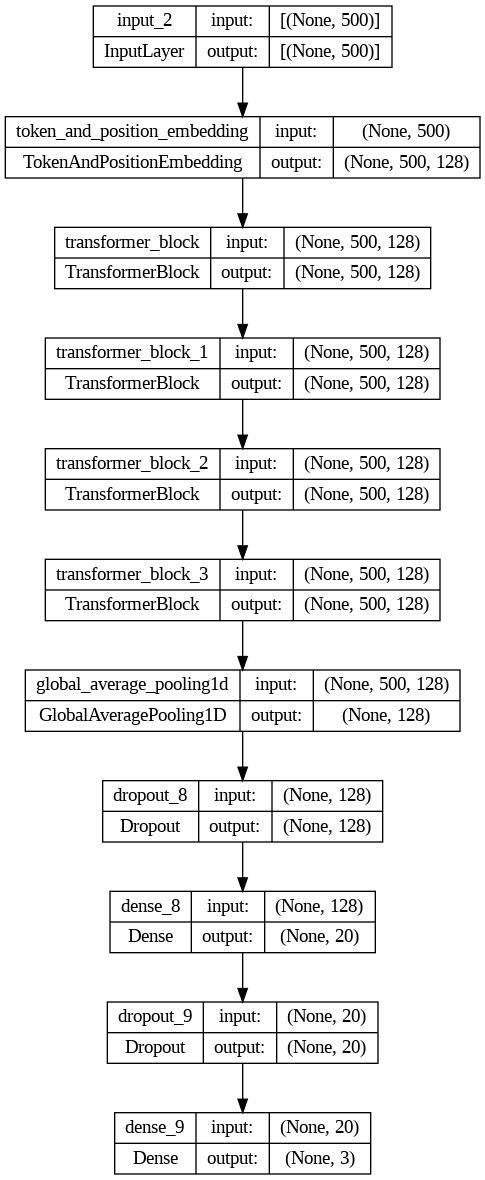

In [ ]:
# Build and compile the model
keras_transformer = tf.keras.Model(inputs=inputs, outputs=outputs)
keras_transformer.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summarize and plot model
keras_transformer.summary()
tf.keras.utils.plot_model(keras_transformer, to_file='model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_keras_transformer.tf', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Define class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
# Train the model
history_kt = keras_transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 747s 592ms/step - loss: 1.1034 - accuracy: 0.2964 - val_loss: 1.1038 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 2/10
1243/1243 [==============================] - 708s 570ms/step - loss: 1.0986 - accuracy: 0.1757 - val_loss: 1.0946 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 3/10
1243/1243 [==============================] - 705s 567ms/step - loss: 1.0987 - accuracy: 0.3265 - val_loss: 1.0889 - val_accuracy: 0.7722 - lr: 0.0010
Epoch 4/10
1243/1243 [==============================] - 699s 562ms/step - loss: 1.0990 - accuracy: 0.4976 - val_loss: 1.1061 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 5/10
1243/1243 [==============================] - 696s 560ms/step - loss: 1.0987 - accuracy: 0.2076 - val_loss: 1.0962 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 6/10
1243/1243 [==============================] - ETA: 0s - loss: 1.0988 - accuracy: 0.2995
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1243/1243 [=========

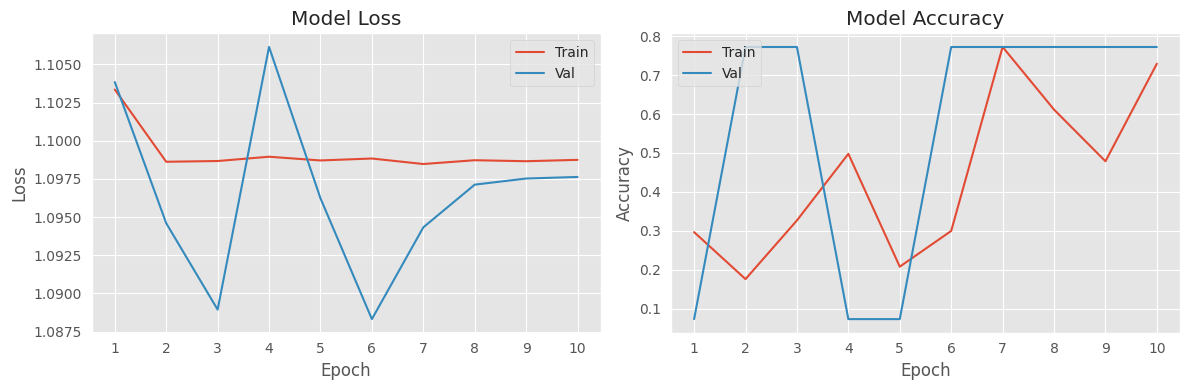

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_kt.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_kt.history['loss'])
plt.plot(epochs_range, history_kt.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_kt.history['accuracy'])
plt.plot(epochs_range, history_kt.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
keras_transformer.load_weights('best_keras_transformer.tf')

# Evaluate the best model on the test set
best_test_loss_kt, best_test_accuracy_kt = keras_transformer.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_kt}")
print(f"Best Model Test Accuracy: {best_test_accuracy_kt}")

266/266 [==============================] - 18s 69ms/step - loss: 1.0883 - accuracy: 0.7723
Best Model Test Loss: 1.088316559791565
Best Model Test Accuracy: 0.7723214030265808


## Switch Transformer

In [16]:
# Token and Position Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [17]:
# Feed Forward Network
def create_feedforward_network(ff_dim, embed_dim, name=None):
    return keras.Sequential(
        [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)], name=name
    )

In [18]:
# Load-balancing Loss
def load_balanced_loss(router_probs, expert_mask):
  num_experts = tf.shape(expert_mask)[-1]

  # Fraction of tokens routed to each expert
  density = tf.reduce_mean(expert_mask, axis=0)

  # Fraction of probability mass assigned to each expert
  density_proxy = tf.reduce_mean(router_probs, axis=0)

  # Calculate the auxiliary loss
  loss = tf.reduce_mean(density_proxy * density) * tf.cast(
      (num_experts**2), tf.dtypes.float32
  )
  return loss

In [19]:
# Router Layer implementation
class Router(layers.Layer):
    def __init__(self, num_experts, expert_capacity):
        self.num_experts = num_experts
        self.route = layers.Dense(units=num_experts)
        self.expert_capacity = expert_capacity
        super().__init__()

    def call(self, inputs, training=False):
        # Generate routing logits for each token to each expert
        router_logits = self.route(inputs)

        # Add exploration noise during training
        if training:
            router_logits += tf.random.uniform(
                shape=router_logits.shape, minval=0.9, maxval=1.1
            )
        # Calculate softmax to get routing probabilities
        router_probs = keras.activations.softmax(router_logits, axis=-1)

        # Select top expert for each token based on probabilities
        expert_gate, expert_index = tf.math.top_k(router_probs, k=1)

        # One-hot encode the selected expert indices
        expert_mask = tf.one_hot(expert_index, depth=self.num_experts)

        # Compute load balancing loss and add it to the layer
        aux_loss = load_balanced_loss(router_probs, expert_mask)
        self.add_loss(aux_loss)

        # Calculate token's position in each expert's queue
        position_in_expert = tf.cast(tf.math.cumsum(expert_mask, axis=0) * expert_mask, tf.dtypes.int32)

        # Ensure token count does not exceed expert capacity
        expert_mask *= tf.cast(
            tf.math.less(tf.cast(position_in_expert, tf.dtypes.int32), self.expert_capacity),
            tf.dtypes.float32,
        )

        # Flatten the expert mask to get final gate values
        expert_mask_flat = tf.reduce_sum(expert_mask, axis=-1)
        expert_gate *= expert_mask_flat

        # Combine expert outputs and scaling with router probability
        combined_tensor = tf.expand_dims(
            expert_gate
            * expert_mask_flat
            * tf.squeeze(tf.one_hot(expert_index, depth=self.num_experts), 1),
            -1,
        ) * tf.squeeze(tf.one_hot(position_in_expert, depth=self.expert_capacity), 1)

        # Create binary dispatch_tensor (1 if routed to corresponding expert)
        dispatch_tensor = tf.cast(combined_tensor, tf.dtypes.float32)

        return dispatch_tensor, combined_tensor

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_experts": self.num_experts,
            "expert_capacity": self.expert_capacity
        })
        return config

In [20]:
# Switch Layer implementation
class Switch(layers.Layer):
    def __init__(
        self, num_experts, embed_dim, ff_dim, num_tokens_per_batch, capacity_factor=1):
        self.num_experts = num_experts
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_tokens_per_batch = num_tokens_per_batch
        self.capacity_factor = capacity_factor
        self.experts = [create_feedforward_network(ff_dim, embed_dim) for _ in range(num_experts)]
        self.expert_capacity = num_tokens_per_batch // self.num_experts
        self.router = Router(self.num_experts, self.expert_capacity)
        super().__init__()

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        num_tokens_per_example = tf.shape(inputs)[1]

        # Reshape inputs for expert processing
        inputs = tf.reshape(inputs, [num_tokens_per_batch, self.embed_dim])

        # Route tokens to experts and get dispatch tensors
        dispatch_tensor, combine_tensor = self.router(inputs)

        # Distribute input tokens to respective experts
        expert_inputs = tf.einsum("ab,acd->cdb", inputs, dispatch_tensor)
        expert_inputs = tf.reshape(
            expert_inputs, [self.num_experts, self.expert_capacity, self.embed_dim]
        )

        # Process tokens with each expert
        expert_input_list = tf.unstack(expert_inputs, axis=0)
        expert_output_list = [
            self.experts[idx](expert_input)
            for idx, expert_input in enumerate(expert_input_list)
        ]

        # Combine expert outputs
        expert_outputs = tf.stack(expert_output_list, axis=1)
        expert_outputs_combined = tf.einsum(
            "abc,xba->xc", expert_outputs, combine_tensor
        )

        # Reshape to original input dimensions
        outputs = tf.reshape(
            expert_outputs_combined,
            [batch_size, num_tokens_per_example, self.embed_dim],
        )

        return outputs

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_experts": self.num_experts,
            "embed_dim": self.embed_dim,
            "ff_dim": self.ff_dim,
            "num_tokens_per_batch": self.num_tokens_per_batch,
            "capacity_factor": self.capacity_factor
        })
        return config

    @classmethod
    def from_config(cls, config):
        # When loading from config, recreate the experts
        new_instance = cls(**config)
        new_instance.experts = [
            create_feedforward_network(config['ff_dim'], config['embed_dim'])
            for _ in range(config['num_experts'])
        ]
        return new_instance

In [21]:
# Transformer Block as a layer
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, ffn, dropout_rate=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim  # Store ff_dim for reconstruction
        self.dropout_rate = dropout_rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = ffn
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout_rate": self.dropout_rate
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Reconstruct the ffn when loading the model from config
        config['ffn'] = create_feedforward_network(config['ff_dim'], config['embed_dim'])
        return cls(**config)

In [22]:
# Set parameters
num_classes = df['Sentiment'].nunique()
vocab_size = len(tokenizer.word_index) + 1
num_tokens_per_example = sequence_length
embed_dim = 32
num_heads = 2
ff_dim = 32
num_experts = 10
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.25
num_epochs = 10
num_tokens_per_batch = (batch_size * num_tokens_per_example)

In [23]:
# Function to build the switch transformer model
def build_switch_transformer():
  switch = Switch(num_experts, embed_dim, ff_dim, num_tokens_per_batch)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, switch, dropout_rate)

  inputs = layers.Input(shape=(num_tokens_per_example,))
  embedding_layer = TokenAndPositionEmbedding(num_tokens_per_example, vocab_size, embed_dim)

  x = embedding_layer(inputs)
  x = transformer_block(x)
  x = layers.GlobalAveragePooling1D()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(ff_dim, activation='relu')(x)
  x = layers.Dropout(dropout_rate)(x)

  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 32)           1544832   
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (32, 500, 32)             29994     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (32, 32)                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (32, 32)                  0     

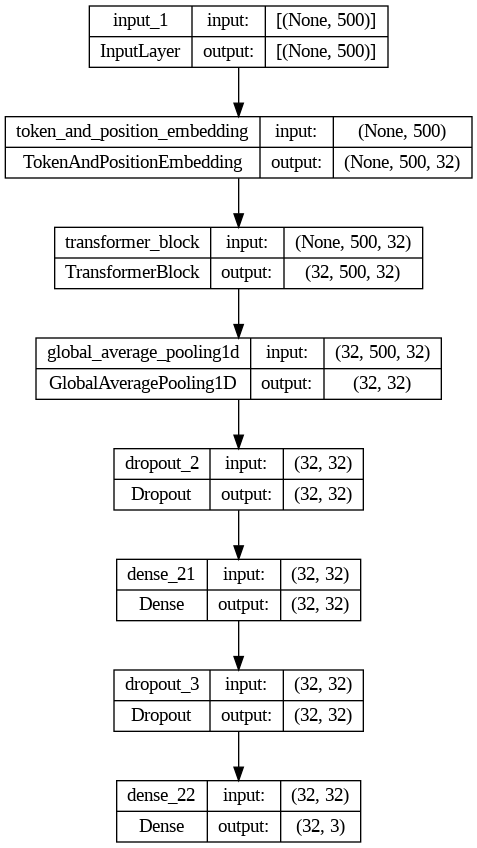

In [ ]:
# Build and compile the model
switch_transformer = build_switch_transformer()
switch_transformer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy']
)

# Summarize and plot model
switch_transformer.summary()
tf.keras.utils.plot_model(switch_transformer, to_file='switch_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_switch_transformer.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_switch = switch_transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 423s 334ms/step - loss: 2.0060 - accuracy: 0.5377 - val_loss: 1.6160 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 2/10
1243/1243 [==============================] - ETA: 0s - loss: 1.6663 - accuracy: 0.7696
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1243/1243 [==============================] - 348s 280ms/step - loss: 1.6663 - accuracy: 0.7696 - val_loss: 1.6232 - val_accuracy: 0.7420 - lr: 0.0010
Epoch 3/10
1243/1243 [==============================] - 349s 280ms/step - loss: 1.4404 - accuracy: 0.8527 - val_loss: 1.5549 - val_accuracy: 0.7855 - lr: 2.0000e-04
Epoch 4/10
1243/1243 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.8712
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1243/1243 [==============================] - 341s 274ms/step - loss: 1.3827 - accuracy: 0.8712 - val_loss: 1.5572 - val_accuracy: 0.7973 - lr: 2.0000e-04
Epoch 5/10
1243/1243

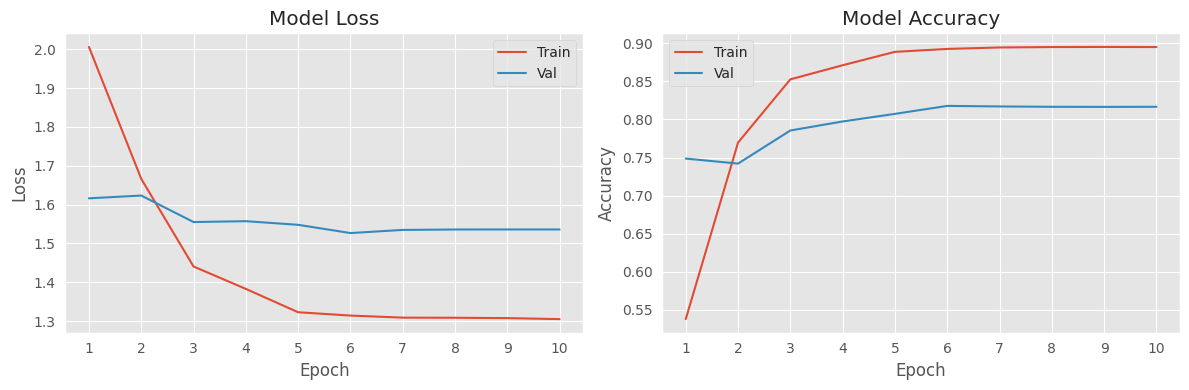

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_switch.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_switch.history['loss'])
plt.plot(epochs_range, history_switch.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_switch.history['accuracy'])
plt.plot(epochs_range, history_switch.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
switch_transformer.load_weights('best_switch_transformer.tf')

# Evaluate the best model on the test set
best_test_loss_switch, best_test_accuracy_switch = switch_transformer.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_switch}")
print(f"Best Model Test Accuracy: {best_test_accuracy_switch}")

266/266 [==============================] - 19s 70ms/step - loss: 1.5360 - accuracy: 0.8138
Best Model Test Loss: 1.5360347032546997
Best Model Test Accuracy: 0.8137922883033752


In [ ]:
# Save the entire model
switch_transformer.save('full_switch_transformer.tf')

# Optimization

## Genetic Algorithm

In [ ]:
!pip install pygad -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 2.2 MB/s eta 0:00:00


In [24]:
from sklearn.utils.class_weight import compute_class_weight

# Define class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
import pygad

# Function to convert TensorFlow dataset to numpy arrays for PyGAD
def dataset_to_numpy(dataset):
    all_elements = list(dataset.as_numpy_iterator())
    inputs = np.concatenate([x for x, _ in all_elements], axis=0)
    outputs = np.concatenate([y for _, y in all_elements], axis=0)
    return inputs, outputs

# Convert the dataset
data_inputs, data_outputs = dataset_to_numpy(train_dataset)

In [25]:
# Function to build the switch transformer
def build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate):
    # Define the input layer
    inputs = layers.Input(shape=(sequence_length,))

    # Embedding layer
    embedding_layer = TokenAndPositionEmbedding(sequence_length, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # Transformer and Switch layers
    switch = Switch(num_experts, embed_dim, ff_dim, num_tokens_per_batch)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, switch, dropout_rate)
    x = transformer_block(x)

    # Additional layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Define the fitness function
def fitness_func(ga_instance, solution, solution_idx):
  global pbar

  # Update the progress bar
  pbar.update(1)

  # Decode the solution into hyperparameters
  embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate = decode_solution(solution)

  # Build the model with these hyperparameters
  model = build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)

  # Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Train the model for a few epochs
  model.fit(data_inputs, data_outputs, epochs=5, verbose=0)

  # Evaluate the model
  loss, accuracy = model.evaluate(data_inputs, data_outputs, verbose=0)

  # Use accuracy as the fitness
  return accuracy

In [ ]:
# Function to decode solution into hyperparameters
def decode_solution(solution):
    # Map the solution array to hyperparameters
    embed_dim = int(solution[0])
    num_heads = int(solution[1])
    ff_dim = int(solution[2])
    num_experts = int(solution[3])
    dropout_rate = min(1.0, max(0.0, solution[4]))
    learning_rate = solution[5]
    return embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate

In [ ]:
# Hyperparameter ranges
init_range_low = [16, 1, 16, 5, 0.0, 0.0001]
init_range_high = [64, 4, 64, 20, 0.5, 0.01]

In [ ]:
# Initialize progress bar
num_generations = 3
sol_per_pop = 3
total_fitness_evaluations = num_generations * sol_per_pop
pbar = tqdm(total=total_fitness_evaluations, desc="Optimizing Hyperparameters")

# Genetic Algorithm Configuration
num_genes = len(init_range_low)  # Number of hyperparameters to optimize
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=3,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=20)

# Run the GA
ga_instance.run()

# Close the progress bar
pbar.close()

Optimizing Hyperparameters: 100%|██████████| 9/9 [5:56:22<00:00, 2375.87s/it]


In [ ]:
# Retrieve the best solution, its fitness, and its index
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()

# Decode the best solution into hyperparameters
best_hyperparameters = decode_solution(best_solution)

# Print the best hyperparameters and their fitness
print("Best Hyperparameters:", best_hyperparameters)
print("Fitness of the Best Hyperparameters:", best_solution_fitness)

Best Hyperparameters: (59, 1, 43, 16, 0.057565388732443434, 0.007427591444259626)
Fitness of the Best Hyperparameters: 0.9760156869888306


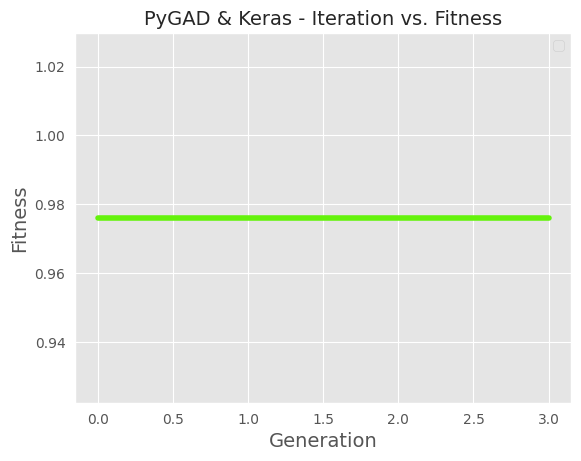

In [ ]:
# Plot the fitness
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4);

In [ ]:
import json

# Convert to a dictionary
hyperparameters_dict = {
    "embed_dim": best_hyperparameters[0],
    "num_heads": best_hyperparameters[1],
    "ff_dim": best_hyperparameters[2],
    "num_experts": best_hyperparameters[3],
    "dropout_rate": best_hyperparameters[4],
    "learning_rate": best_hyperparameters[5]
}

# Save to a JSON file
with open('best_hyperparameters.json', 'w') as file:
    json.dump(hyperparameters_dict, file, indent=4)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 59)           2848284   
 ng_13 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_15 (Tran  (32, 500, 59)             98172     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_1  (32, 59)                  0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_56 (Dropout)        (32, 59)                  0  

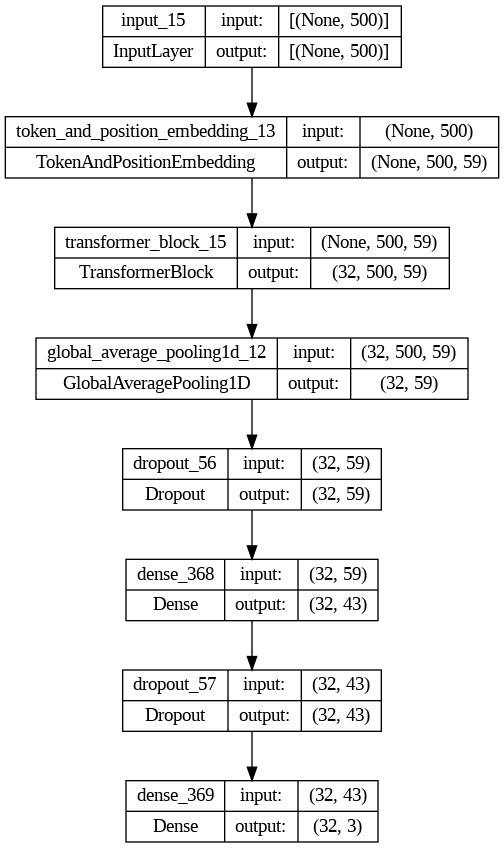

In [ ]:
# Rebuild the model using the best hyperparameters
ga_opt_model = build_switch_transformer(*best_hyperparameters)

# Compile the model
ga_opt_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters[-1]),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summarize and plot model
ga_opt_model.summary()
tf.keras.utils.plot_model(ga_opt_model, to_file='ga_opt_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='ga_opt_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_ga = ga_opt_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 541s 427ms/step - loss: 2.0717 - accuracy: 0.4850 - val_loss: 1.8295 - val_accuracy: 0.6564 - lr: 0.0074
Epoch 2/10
1243/1243 [==============================] - ETA: 0s - loss: 1.8896 - accuracy: 0.6892
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0014855182729661466.
1243/1243 [==============================] - 453s 365ms/step - loss: 1.8896 - accuracy: 0.6892 - val_loss: 1.8570 - val_accuracy: 0.6528 - lr: 0.0074
Epoch 3/10
1243/1243 [==============================] - 460s 370ms/step - loss: 1.7615 - accuracy: 0.7352 - val_loss: 1.6781 - val_accuracy: 0.7137 - lr: 0.0015
Epoch 4/10
1243/1243 [==============================] - ETA: 0s - loss: 1.7095 - accuracy: 0.7503
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00029710365924984217.
1243/1243 [==============================] - 453s 365ms/step - loss: 1.7095 - accuracy: 0.7503 - val_loss: 1.6826 - val_accuracy: 0.7085 - lr: 0.0015
Epoch 5/10
1243/1243 [=======

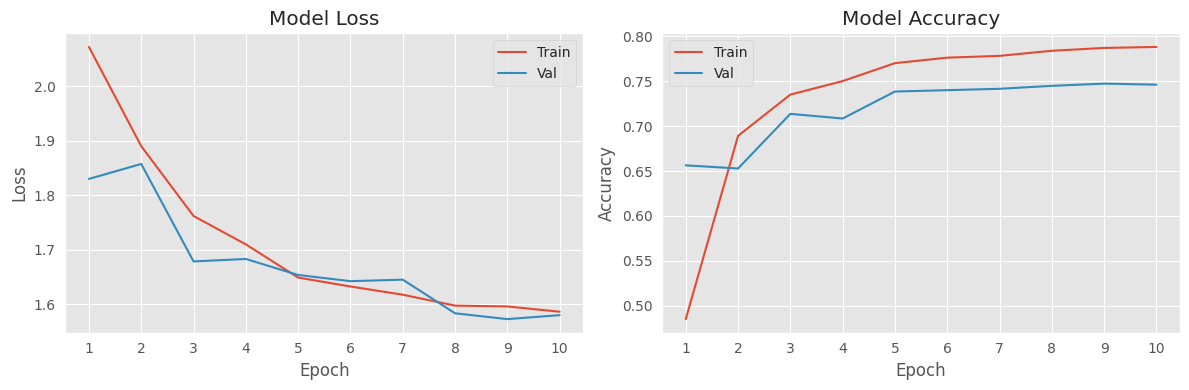

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_ga.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_ga.history['loss'])
plt.plot(epochs_range, history_ga.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_ga.history['accuracy'])
plt.plot(epochs_range, history_ga.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
ga_opt_model.load_weights('ga_opt_model.tf')

# Evaluate the best model on the test set
best_test_loss_ga, best_test_accuracy_ga = ga_opt_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_ga}")
print(f"Best Model Test Accuracy: {best_test_accuracy_ga}")

266/266 [==============================] - 18s 69ms/step - loss: 1.5866 - accuracy: 0.7412
Best Model Test Loss: 1.5865917205810547
Best Model Test Accuracy: 0.7411888837814331


In [ ]:
# Save the retrained model
ga_opt_model.save('ga_retrained_model.tf')

## Particle Swarm

In [ ]:
!pip install mealpy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.6 MB/s eta 0:00:00


In [ ]:
import mealpy
from mealpy.swarm_based import PSO
from mealpy.utils.space import FloatVar
from opfunu.type_based.uni_modal import Functions

# Define the objective function
def objective_function(solution):
    embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate = solution

    # Convert to correct types
    embed_dim, num_heads, ff_dim, num_experts = map(int, [embed_dim, num_heads, ff_dim, num_experts])

    # Build and train the model
    model = build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=5, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(val_dataset, verbose=0)
    return loss  # or return 1 - accuracy if maximizing accuracy

In [ ]:
# Define bounds for hyperparameters using FloatVar
problem_bounds = [
    FloatVar(lb=16, ub=128),   # embed_dim
    FloatVar(lb=1, ub=8),      # num_heads
    FloatVar(lb=16, ub=128),   # ff_dim
    FloatVar(lb=1, ub=20),     # num_experts
    FloatVar(lb=0.0, ub=0.5),  # dropout_rate
    FloatVar(lb=1e-6, ub=1e-1) # learning_rate
]

# Create a problem dictionary
problem_dict = {
    "bounds": problem_bounds,
    "obj_func": objective_function,
    "minmax": "min",
    "log_to": "console",
}

# PSO configuration
epoch = 3
pop_size = 5

# Initialize the PSO model
pso_model = PSO.OriginalPSO(epoch=epoch, pop_size=pop_size, c1=2.05, c2=2.05, w=0.4)

# Run the PSO algorithm
g_best = pso_model.solve(problem_dict)

# Print the best solution and its fitness
print(f"Best Parameters: {g_best.solution}")
print(f"Best Loss: {g_best.target.fitness}")

INFO:mealpy.swarm_based.PSO.OriginalPSO:Solving single objective optimization problem.
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 1, Current best: 1.4572659730911255, Global best: 1.4572659730911255, Runtime: 13581.08988 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 2, Current best: 1.4548348188400269, Global best: 1.4548348188400269, Runtime: 12380.67866 seconds
INFO:mealpy.swarm_based.PSO.OriginalPSO:>>>Problem: P, Epoch: 3, Current best: 1.4548348188400269, Global best: 1.4548348188400269, Runtime: 10487.18104 seconds
Optimizing Hyperparameters:   0%|          | 0/15 [16:21:18<?, ?it/s]

Best Parameters: [5.24394300e+01 2.06046875e+00 7.61803893e+01 1.78063730e+01
 4.95001296e-02 7.50383125e-03]
Best Loss: 1.4548348188400269


In [ ]:
# Saving the best hyperparameters
best_solution = g_best.solution
best_hyperparameters = {
    "embed_dim": int(best_solution[0]),
    "num_heads": int(best_solution[1]),
    "ff_dim": int(best_solution[2]),
    "num_experts": int(best_solution[3]),
    "dropout_rate": best_solution[4],
    "learning_rate": best_solution[5]
}

with open('best_hyperparameters.json', 'w') as file:
    json.dump(best_hyperparameters, file, indent=4)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 52)           2510352   
 ng_28 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_31 (Tran  (32, 500, 52)             159649    
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_2  (32, 52)                  0         
 8 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_120 (Dropout)       (32, 52)                  0  

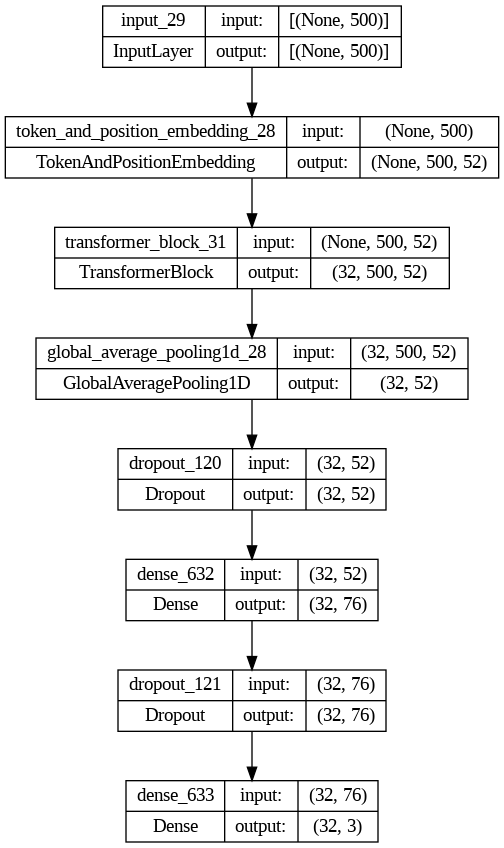

In [ ]:
# Rebuild and retrain the model with the best hyperparameters
pso_model = build_switch_transformer(**best_hyperparameters)
pso_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summarize and plot model
pso_model.summary()
tf.keras.utils.plot_model(pso_model, to_file='pso_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='pso_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_pso = pso_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 553s 435ms/step - loss: 2.0323 - accuracy: 0.5817 - val_loss: 1.7955 - val_accuracy: 0.6990 - lr: 0.0075
Epoch 2/10
1243/1243 [==============================] - 481s 387ms/step - loss: 1.8084 - accuracy: 0.7169 - val_loss: 1.5475 - val_accuracy: 0.7845 - lr: 0.0075
Epoch 3/10
1243/1243 [==============================] - ETA: 0s - loss: 1.7468 - accuracy: 0.7402
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.001500766258686781.
1243/1243 [==============================] - 467s 376ms/step - loss: 1.7468 - accuracy: 0.7402 - val_loss: 1.6578 - val_accuracy: 0.7168 - lr: 0.0075
Epoch 4/10
1243/1243 [==============================] - ETA: 0s - loss: 1.6383 - accuracy: 0.7785
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003001532517373562.
1243/1243 [==============================] - 466s 375ms/step - loss: 1.6383 - accuracy: 0.7785 - val_loss: 1.6018 - val_accuracy: 0.7686 - lr: 0.0015
Epoch 5/10
1243/1243 [=========

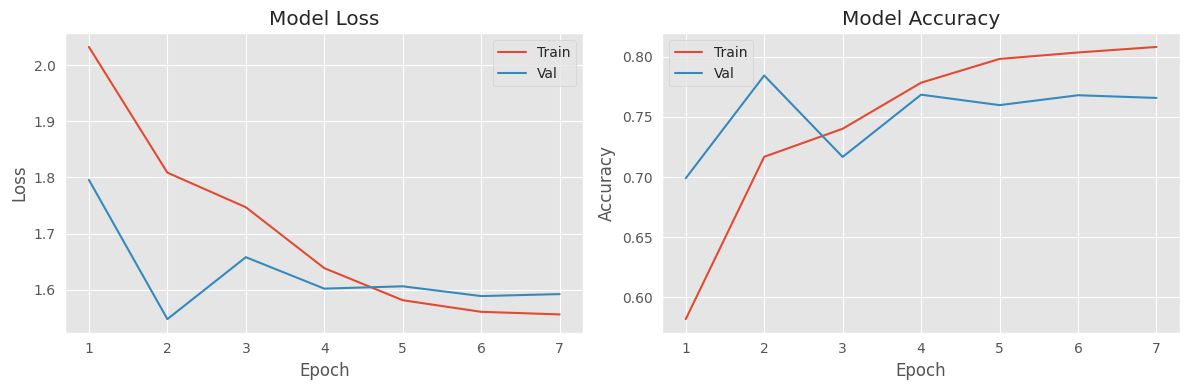

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_pso.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_pso.history['loss'])
plt.plot(epochs_range, history_pso.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_pso.history['accuracy'])
plt.plot(epochs_range, history_pso.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
pso_model.load_weights('pso_model.tf')

# Evaluate the best model on the test set
best_test_loss_pso, best_test_accuracy_pso = pso_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_pso}")
print(f"Best Model Test Accuracy: {best_test_accuracy_pso}")

266/266 [==============================] - 22s 81ms/step - loss: 1.5490 - accuracy: 0.7797
Best Model Test Loss: 1.549007773399353
Best Model Test Accuracy: 0.7797227501869202


In [ ]:
# Save the retrained model
pso_model.save('pso_retrained_model.tf')

## Gray Wolf

In [ ]:
import mealpy
from mealpy.swarm_based import GWO
from mealpy.utils.space import FloatVar
from opfunu.type_based.uni_modal import Functions

# Define the objective function
def objective_function(solution):
    embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate = solution

    # Convert to correct types
    embed_dim, num_heads, ff_dim, num_experts = map(int, [embed_dim, num_heads, ff_dim, num_experts])

    # Build and train the model
    model = build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=5, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(val_dataset, verbose=0)
    return loss  # or return 1 - accuracy if maximizing accuracy

In [ ]:
# Define bounds for hyperparameters using FloatVar
problem_bounds = [
    FloatVar(lb=16, ub=128),   # embed_dim
    FloatVar(lb=1, ub=8),      # num_heads
    FloatVar(lb=16, ub=128),   # ff_dim
    FloatVar(lb=1, ub=20),     # num_experts
    FloatVar(lb=0.0, ub=0.5),  # dropout_rate
    FloatVar(lb=1e-6, ub=1e-1) # learning_rate
]

# Create a problem dictionary
problem_dict = {
    "bounds": problem_bounds,
    "obj_func": objective_function,
    "minmax": "min",
    "log_to": "console",
}

# GWO configuration
epoch = 3
pop_size = 5

# Initialize the GWO model
gwo_model = GWO.OriginalGWO(epoch=epoch, pop_size=pop_size)

# Run the GWO algorithm
g_best = gwo_model.solve(problem_dict)

# Print the best solution and its fitness
print(f"Best Parameters: {g_best.solution}")
print(f"Best Loss: {g_best.target.fitness}")

INFO:mealpy.swarm_based.GWO.OriginalGWO:Solving single objective optimization problem.
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 1, Current best: 1.4345383644104004, Global best: 1.4345383644104004, Runtime: 14584.47127 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 2, Current best: 1.4345383644104004, Global best: 1.4345383644104004, Runtime: 13254.31161 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: P, Epoch: 3, Current best: 1.4345383644104004, Global best: 1.4345383644104004, Runtime: 15461.59466 seconds


Best Parameters: [9.66430684e+01 5.61966907e+00 8.67762117e+01 5.96884904e+00
 1.35823449e-02 9.43054712e-03]
Best Loss: 1.4345383644104004


In [ ]:
# Saving the best hyperparameters
best_solution = g_best.solution
best_hyperparameters = {
    "embed_dim": int(best_solution[0]),
    "num_heads": int(best_solution[1]),
    "ff_dim": int(best_solution[2]),
    "num_experts": int(best_solution[3]),
    "dropout_rate": best_solution[4],
    "learning_rate": best_solution[5]
}

with open('best_hyperparameters.json', 'w') as file:
    json.dump(best_hyperparameters, file, indent=4)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 96)           4634496   
 ng_21 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_21 (Tran  (32, 500, 96)             270195    
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_2  (32, 96)                  0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_86 (Dropout)        (32, 96)                  0  

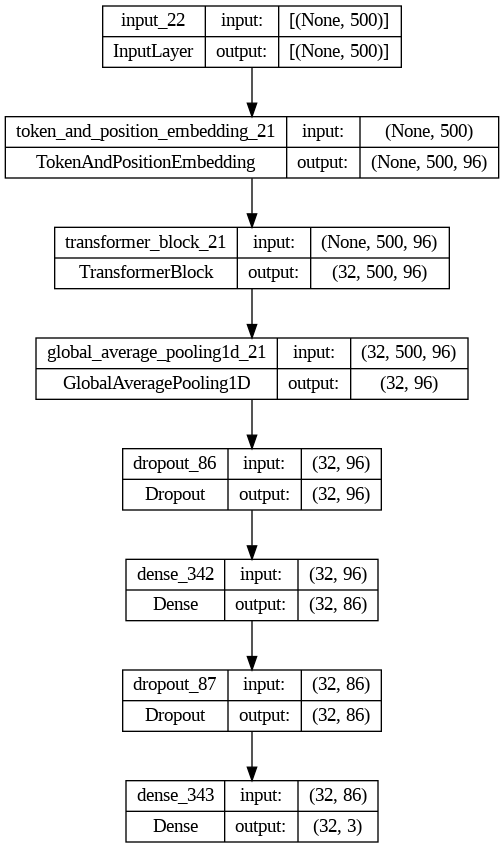

In [ ]:
# Rebuild and retrain the model with the best hyperparameters
gwo_model = build_switch_transformer(**best_hyperparameters)
gwo_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters["learning_rate"]),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Summarize and plot model
gwo_model.summary()
tf.keras.utils.plot_model(gwo_model, to_file='gwo_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='gwo_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_gwo = gwo_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 731s 582ms/step - loss: 2.4218 - accuracy: 0.2505 - val_loss: 2.3829 - val_accuracy: 0.0728 - lr: 0.0094
Epoch 2/10
1243/1243 [==============================] - ETA: 0s - loss: 2.3615 - accuracy: 0.3138
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0018861094489693643.
1243/1243 [==============================] - 672s 541ms/step - loss: 2.3615 - accuracy: 0.3138 - val_loss: 2.3763 - val_accuracy: 0.1550 - lr: 0.0094
Epoch 3/10
1243/1243 [==============================] - 666s 536ms/step - loss: 2.3490 - accuracy: 0.3009 - val_loss: 2.3469 - val_accuracy: 0.1550 - lr: 0.0019
Epoch 4/10
1243/1243 [==============================] - 663s 533ms/step - loss: 2.3499 - accuracy: 0.2525 - val_loss: 2.2547 - val_accuracy: 0.1550 - lr: 0.0019
Epoch 5/10
1243/1243 [==============================] - 661s 532ms/step - loss: 2.1005 - accuracy: 0.2565 - val_loss: 2.1102 - val_accuracy: 0.0728 - lr: 0.0019
Epoch 6/10
1243/1243 [==========

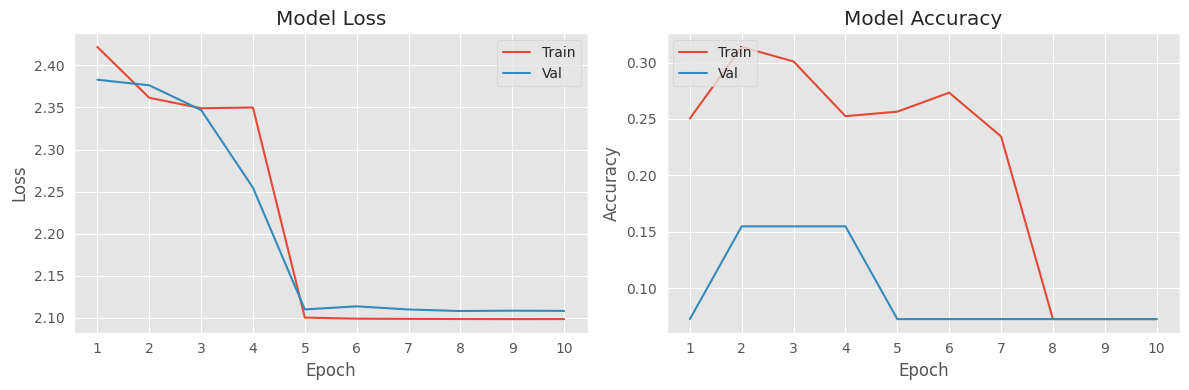

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_gwo.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_gwo.history['loss'])
plt.plot(epochs_range, history_gwo.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_gwo.history['accuracy'])
plt.plot(epochs_range, history_gwo.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
gwo_model.load_weights('gwo_model.tf')

# Evaluate the best model on the test set
best_test_loss_gwo, best_test_accuracy_gwo = gwo_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_gwo}")
print(f"Best Model Test Accuracy: {best_test_accuracy_gwo}")

266/266 [==============================] - 27s 101ms/step - loss: 2.1083 - accuracy: 0.0728
Best Model Test Loss: 2.108276844024658
Best Model Test Accuracy: 0.07283834367990494


In [ ]:
# Save the retrained model
gwo_model.save('gwo_retrained_model.tf')

## Differential Evolution

In [ ]:
!pip install pymoo -q

In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize

# Define the optimization problem class
class SwitchTransformerOptimizationProblem(ElementwiseProblem):
    def __init__(self, train_dataset, val_dataset, **kwargs):
        super().__init__(n_var=6,  # Number of hyperparameters
                         n_obj=1,  # Single-objective
                         n_constr=0,  # No constraints
                         xl=np.array([16, 1, 16, 1, 0.0, 1e-4]),   # Lower bounds
                         xu=np.array([64, 4, 64, 20, 0.5, 1e-2]),  # Upper bounds
                         **kwargs)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

    def _evaluate(self, x, out, *args, **kwargs):
        embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate = map(int, x)
        model = build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(self.train_dataset, epochs=5, verbose=0)
        loss, _ = model.evaluate(self.val_dataset, verbose=0)
        out["F"] = np.array([loss])

In [ ]:
# Define the problem and algorithm
problem = SwitchTransformerOptimizationProblem(train_dataset, val_dataset)

algorithm = DE(pop_size=5, variant="DE/rand/1/bin", CR=0.5, F=0.3, dither="vector")

res = minimize(problem,
               algorithm,
               ('n_gen', 3),
               verbose=True)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        5 |  3.4102562904 |  2.9748783112
     2 |       10 |  2.6086841106 |  2.5538496971
     3 |       15 |  2.3962741375 |  2.0714037418


In [ ]:
# Get the best hyperparameters
best_hyperparameters = res.X
best_loss = res.F
print("Best Hyperparameters:", best_hyperparameters)
print("Best Loss:", best_loss)

Best Hyperparameters: [1.80642564e+01 1.01203215e+00 4.68865955e+01 3.81220393e+00
 8.34201189e-02 6.82405128e-03]
Best Loss: [2.07140374]


In [ ]:
# Save best hyperparameters
best_hyperparameters_dict = {
    "embed_dim": int(best_hyperparameters[0]),
    "num_heads": int(best_hyperparameters[1]),
    "ff_dim": int(best_hyperparameters[2]),
    "num_experts": int(best_hyperparameters[3]),
    "dropout_rate": best_hyperparameters[4],
    "learning_rate": best_hyperparameters[5]
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters_dict, f, indent=4)

In [ ]:
# # Load the best hyperparameters from the JSON file
# with open('best_hyperparameters.json', 'r') as file:
#     loaded_hyperparameters = json.load(file)

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 18)           868968    
 ng_16 (TokenAndPositionEmb                                      
 edding)                                                         
                                                                 
 transformer_block_16 (Tran  (32, 500, 18)             6657      
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_1  (32, 18)                  0         
 6 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_66 (Dropout)        (32, 18)                  0  

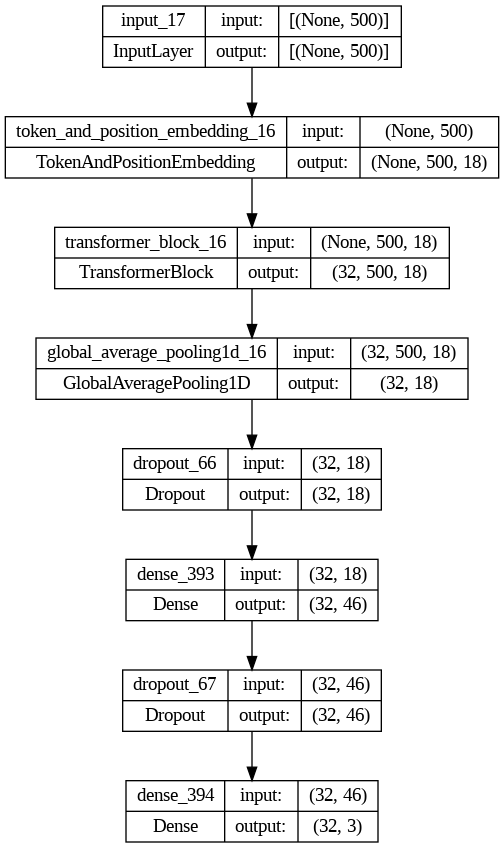

In [ ]:
# Rebuild and retrain the model
de_opt_model = build_switch_transformer(**best_hyperparameters_dict)
de_opt_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters[-1]),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summarize and plot model
de_opt_model.summary()
tf.keras.utils.plot_model(de_opt_model, to_file='de_opt_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='de_opt_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_de = de_opt_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 366s 290ms/step - loss: 1.9690 - accuracy: 0.5926 - val_loss: 1.5766 - val_accuracy: 0.7489 - lr: 0.0068
Epoch 2/10
1243/1243 [==============================] - 304s 245ms/step - loss: 1.7046 - accuracy: 0.7556 - val_loss: 1.4894 - val_accuracy: 0.7943 - lr: 0.0068
Epoch 3/10
1243/1243 [==============================] - 294s 236ms/step - loss: 1.5254 - accuracy: 0.8206 - val_loss: 1.4344 - val_accuracy: 0.8428 - lr: 0.0068
Epoch 4/10
1243/1243 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.8724
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0013648102991282941.
1243/1243 [==============================] - 291s 234ms/step - loss: 1.3604 - accuracy: 0.8724 - val_loss: 1.6618 - val_accuracy: 0.7702 - lr: 0.0068
Epoch 5/10
1243/1243 [==============================] - ETA: 0s - loss: 1.1798 - accuracy: 0.9326
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00027296205516904595.
1243/1243 [=======

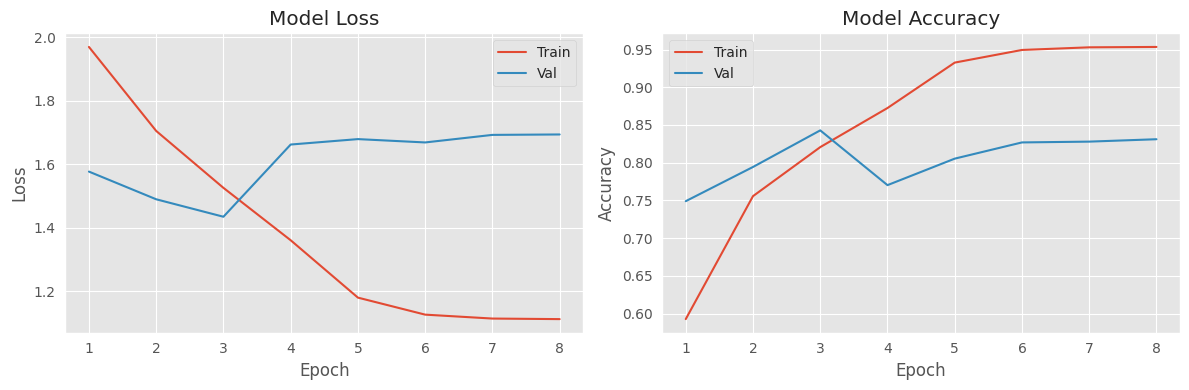

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_de.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_de.history['loss'])
plt.plot(epochs_range, history_de.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_de.history['accuracy'])
plt.plot(epochs_range, history_de.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
de_opt_model.load_weights('de_opt_model.tf')

# Evaluate the best model on the test set
best_test_loss_de, best_test_accuracy_de = de_opt_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_de}")
print(f"Best Model Test Accuracy: {best_test_accuracy_de}")

266/266 [==============================] - 19s 71ms/step - loss: 1.4356 - accuracy: 0.8401
Best Model Test Loss: 1.4355576038360596
Best Model Test Accuracy: 0.8401080965995789


In [ ]:
# Save the retrained model
de_opt_model.save('de_retrained_model.tf')

## Simulated Annealing

In [ ]:
from scipy.optimize import dual_annealing

# Objective function for optimization
def objective_function(hyperparams):
    embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate = hyperparams

    # Ensure hyperparameters are in the correct format
    embed_dim, num_heads, ff_dim, num_experts = map(int, [embed_dim, num_heads, ff_dim, num_experts])

    # Build, compile, and train the model
    model = build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=5, verbose=0)

    # Evaluate the model
    loss, _ = model.evaluate(val_dataset, verbose=0)
    return loss

In [ ]:
# Define bounds for hyperparameters
bounds = [(16, 64), (1, 4), (16, 64), (1, 20), (0.0, 0.5), (1e-4, 1e-2)]

# Run Simulated Annealing
result = dual_annealing(
    objective_function,
    bounds=bounds,
    maxiter=5,
    maxfun=5,
    no_local_search=True
)

In [ ]:
# Extract the best solution
best_hyperparameters = result.x
best_loss = result.fun

print("Best Hyperparameters:", best_hyperparameters)
print("Best Loss:", best_loss)

Best Hyperparameters: [3.17731731e+01 2.66243113e+00 5.29274575e+01 7.21415865e+00
 1.89174753e-01 4.07511176e-04]
Best Loss: 1.454257845878601


In [ ]:
# Save best hyperparameters
best_hyperparameters_dict = {
    "embed_dim": int(best_hyperparameters[0]),
    "num_heads": int(best_hyperparameters[1]),
    "ff_dim": int(best_hyperparameters[2]),
    "num_experts": int(best_hyperparameters[3]),
    "dropout_rate": best_hyperparameters[4],
    "learning_rate": best_hyperparameters[5]
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters_dict, f, indent=4)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 31)           1496556   
 ng_5 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_5 (Trans  (32, 500, 31)             31402     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_5  (32, 31)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_22 (Dropout)        (32, 31)                  0   

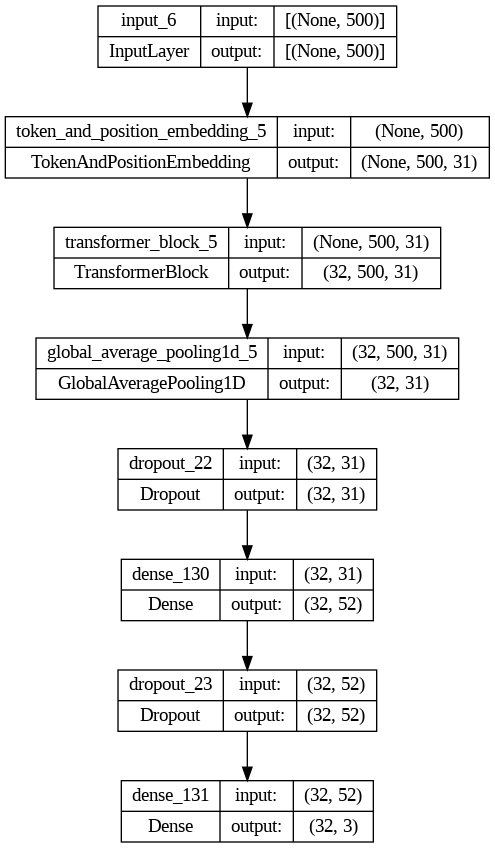

In [ ]:
# Rebuild the model with the best hyperparameters
sa_model = build_switch_transformer(**best_hyperparameters_dict)

# Compile the model
sa_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters_dict["learning_rate"]),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Summarize and plot model
sa_model.summary()
tf.keras.utils.plot_model(sa_model, to_file='sa_model.png', show_shapes=True)

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='sa_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [ ]:
# Train the model
history_sa = sa_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 451s 358ms/step - loss: 2.0839 - accuracy: 0.4432 - val_loss: 2.2449 - val_accuracy: 0.1595 - lr: 4.0751e-04
Epoch 2/10
1243/1243 [==============================] - 386s 310ms/step - loss: 1.8009 - accuracy: 0.7112 - val_loss: 1.6234 - val_accuracy: 0.7440 - lr: 4.0751e-04
Epoch 3/10
1243/1243 [==============================] - 380s 306ms/step - loss: 1.5701 - accuracy: 0.8060 - val_loss: 1.6084 - val_accuracy: 0.7559 - lr: 4.0751e-04
Epoch 4/10
1243/1243 [==============================] - 375s 302ms/step - loss: 1.4344 - accuracy: 0.8530 - val_loss: 1.4661 - val_accuracy: 0.8219 - lr: 4.0751e-04
Epoch 5/10
1243/1243 [==============================] - ETA: 0s - loss: 1.3280 - accuracy: 0.8849
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.150223293341697e-05.
1243/1243 [==============================] - 372s 299ms/step - loss: 1.3280 - accuracy: 0.8849 - val_loss: 1.6324 - val_accuracy: 0.7782 - lr: 4.0751e-04
Epoch 6/10
1

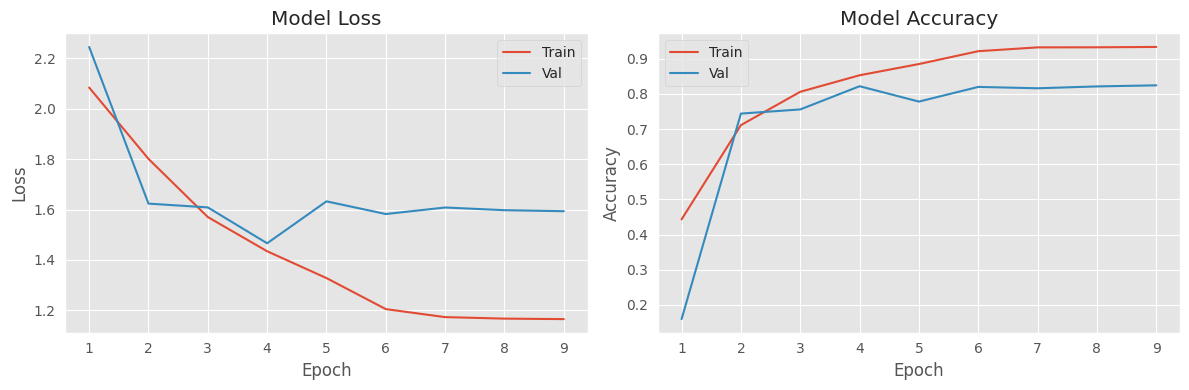

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_sa.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_sa.history['loss'])
plt.plot(epochs_range, history_sa.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_sa.history['accuracy'])
plt.plot(epochs_range, history_sa.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best saved model
sa_model.load_weights('sa_model.tf')

# Evaluate the best model on the test set
best_test_loss_sa, best_test_accuracy_sa = sa_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_sa}")
print(f"Best Model Test Accuracy: {best_test_accuracy_sa}")

266/266 [==============================] - 20s 75ms/step - loss: 1.4730 - accuracy: 0.8213
Best Model Test Loss: 1.4729691743850708
Best Model Test Accuracy: 0.8213111162185669


In [ ]:
# Save the retrained model
sa_model.save('sa_retrained_model.tf')

## Hyperband

In [26]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [27]:
from keras_tuner import HyperModel, Hyperband

# Define the HyperModel
class SwitchTransformerHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Define hyperparameters
        embed_dim = hp.Int('embed_dim', min_value=16, max_value=64, step=16)
        num_heads = hp.Int('num_heads', min_value=2, max_value=10, step=2)
        ff_dim = hp.Int('ff_dim', min_value=16, max_value=64, step=16)
        num_experts = hp.Int('num_experts', min_value=1, max_value=10, step=1)
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

        # Build the model
        return build_switch_transformer(embed_dim, num_heads, ff_dim, num_experts, dropout_rate, learning_rate)

In [28]:
# Initialize the HyperModel
hypermodel = SwitchTransformerHyperModel(input_shape=(sequence_length,))

# Configure the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner_dir',
    project_name='switch_transformer_tuning'
)

# Start the search
tuner.search(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Trial 10 Complete [00h 45m 24s]
val_accuracy: 0.8590225577354431

Best val_accuracy So Far: 0.8630169034004211
Total elapsed time: 03h 47m 56s


In [29]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print("Embed Dim:", best_hps.get('embed_dim'))
print("Num Heads:", best_hps.get('num_heads'))
print("FF Dim:", best_hps.get('ff_dim'))
print("Num Experts:", best_hps.get('num_experts'))
print("Dropout Rate:", best_hps.get('dropout_rate'))
print("Learning Rate:", best_hps.get('learning_rate'))

Best Hyperparameters:
Embed Dim: 16
Num Heads: 4
FF Dim: 48
Num Experts: 2
Dropout Rate: 0.2
Learning Rate: 0.0010153958908885


In [30]:
# Save best hyperparameters
best_hyperparameters_dict = {
    "embed_dim": best_hps.get('embed_dim'),
    "num_heads": best_hps.get('num_heads'),
    "ff_dim": best_hps.get('ff_dim'),
    "num_experts": best_hps.get('num_experts'),
    "dropout_rate": best_hps.get('dropout_rate'),
    "learning_rate": best_hps.get('learning_rate')
}

with open('best_hyperparameters_kt.json', 'w') as f:
    json.dump(best_hyperparameters_dict, f, indent=4)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 16)           772416    
 ng_1 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_1 (Trans  (32, 500, 16)             7602      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (32, 16)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_6 (Dropout)         (32, 16)                  0   

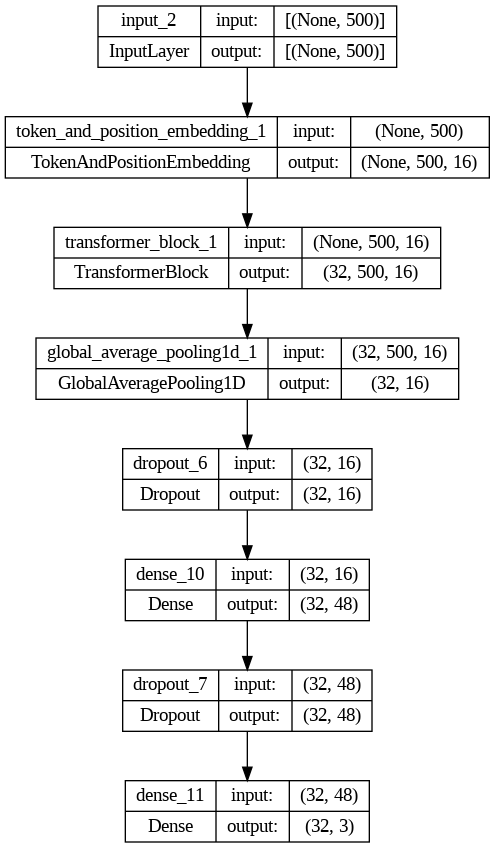

In [31]:
# Rebuild the model with the best hyperparameters
ktuner_model = build_switch_transformer(**best_hyperparameters_dict)

# Compile the model
ktuner_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters_dict["learning_rate"]),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Summarize and plot model
ktuner_model.summary()
tf.keras.utils.plot_model(ktuner_model, to_file='ktuner_model.png', show_shapes=True)

In [32]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='ktuner_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [33]:
# Train the model
history_ktuner = ktuner_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 343s 272ms/step - loss: 2.0825 - accuracy: 0.4183 - val_loss: 2.0719 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 2/10
1243/1243 [==============================] - 288s 232ms/step - loss: 1.8840 - accuracy: 0.6728 - val_loss: 1.6544 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 3/10
1243/1243 [==============================] - 279s 224ms/step - loss: 1.6358 - accuracy: 0.7963 - val_loss: 1.5619 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 4/10
1243/1243 [==============================] - 278s 223ms/step - loss: 1.4625 - accuracy: 0.8446 - val_loss: 1.5026 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 5/10
1243/1243 [==============================] - ETA: 0s - loss: 1.3333 - accuracy: 0.8828
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020307917147874833.
1243/1243 [==============================] - 275s 221ms/step - loss: 1.3333 - accuracy: 0.8828 - val_loss: 1.5880 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 6/10
1243/1243 [=========

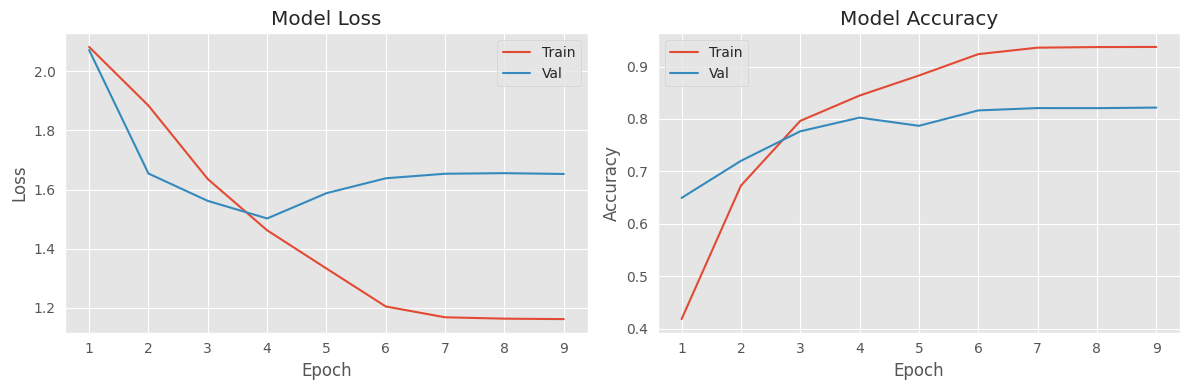

In [34]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_ktuner.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_ktuner.history['loss'])
plt.plot(epochs_range, history_ktuner.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_ktuner.history['accuracy'])
plt.plot(epochs_range, history_ktuner.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
# Load the best saved model
ktuner_model.load_weights('ktuner_model.tf')

# Evaluate the best model on the test set
best_test_loss_ktuner, best_test_accuracy_ktuner = ktuner_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_ktuner}")
print(f"Best Model Test Accuracy: {best_test_accuracy_ktuner}")

266/266 [==============================] - 19s 71ms/step - loss: 1.5018 - accuracy: 0.8024
Best Model Test Loss: 1.5018435716629028
Best Model Test Accuracy: 0.8023965954780579


In [36]:
# Save the retrained model
ktuner_model.save('ktuner_retrained_model.tf')

# Model Selection

In [37]:
# List of the models
models = [
    "Original",
    "Genetic Algorithm",
    "PSO",
    "Gray Wolf",
    "Differential Evolution",
    "Simulated Annealing",
    "Hyperband"
]

In [38]:
# Test losses and accuracies
test_losses = [
    1.5360347032546997,  # Original
    1.5865917205810547,  # Genetic Algorithm
    1.549007773399353,   # PSO
    2.108276844024658,   # Gray Wolf
    1.4355576038360596,  # Differential Evolution
    1.4729691743850708,  # Simulated Annealing
    1.5018435716629028   # Hyperband
]

test_accuracies = [
    0.8137922883033752,  # Original
    0.7411888837814331,  # Genetic Algorithm
    0.7797227501869202,  # PSO
    0.07283834367990494, # Gray Wolf
    0.8401080965995789,  # Differential Evolution
    0.8213111162185669,  # Simulated Annealing
    0.8023965954780579   # Hyperband
]

In [39]:
# Hyperparameters for each model
hyperparameters = [
    {"embed_dim": 32, "num_heads": 2, "ff_dim": 32, "num_experts": 10, "dropout_rate": 0.25, "learning_rate": 0.001}, # Original
    {"embed_dim": 59, "num_heads": 1, "ff_dim": 43, "num_experts": 16, "dropout_rate": 0.057565388732443434, "learning_rate": 0.007427591444259626}, # Genetic Algorithm
    {"embed_dim": 52, "num_heads": 2, "ff_dim": 76, "num_experts": 17, "dropout_rate": 0.0495001296, "learning_rate": 0.00750383125}, # PSO
    {"embed_dim": 96, "num_heads": 5, "ff_dim": 86, "num_experts": 5, "dropout_rate": 0.0135823449, "learning_rate": 0.00943054712}, # Gray Wolf
    {"embed_dim": 18, "num_heads": 1, "ff_dim": 46, "num_experts": 3, "dropout_rate": 0.0834201189, "learning_rate": 0.00682405128}, # Differential Evolution
    {"embed_dim": 31, "num_heads": 2, "ff_dim": 52, "num_experts": 7, "dropout_rate": 0.189174753, "learning_rate": 0.000407511176}, # Simulated Annealing
    {"embed_dim": 16, "num_heads": 4, "ff_dim": 48, "num_experts": 2, "dropout_rate": 0.2, "learning_rate": 0.0010153958908885} # Hyperband
]

# Create DataFrame for hyperparameters
df_hyperparameters = pd.DataFrame(hyperparameters, index=models)
df_hyperparameters

,embed_dim,num_heads,ff_dim,num_experts,dropout_rate,learning_rate
Original,32,2,32,10,0.250000,0.001000
Genetic Algorithm,59,1,43,16,0.057565,0.007428
PSO,52,2,76,17,0.049500,0.007504
Gray Wolf,96,5,86,5,0.013582,0.009431
Differential Evolution,18,1,46,3,0.083420,0.006824
Simulated Annealing,31,2,52,7,0.189175,0.000408
Hyperband,16,4,48,2,0.200000,0.001015


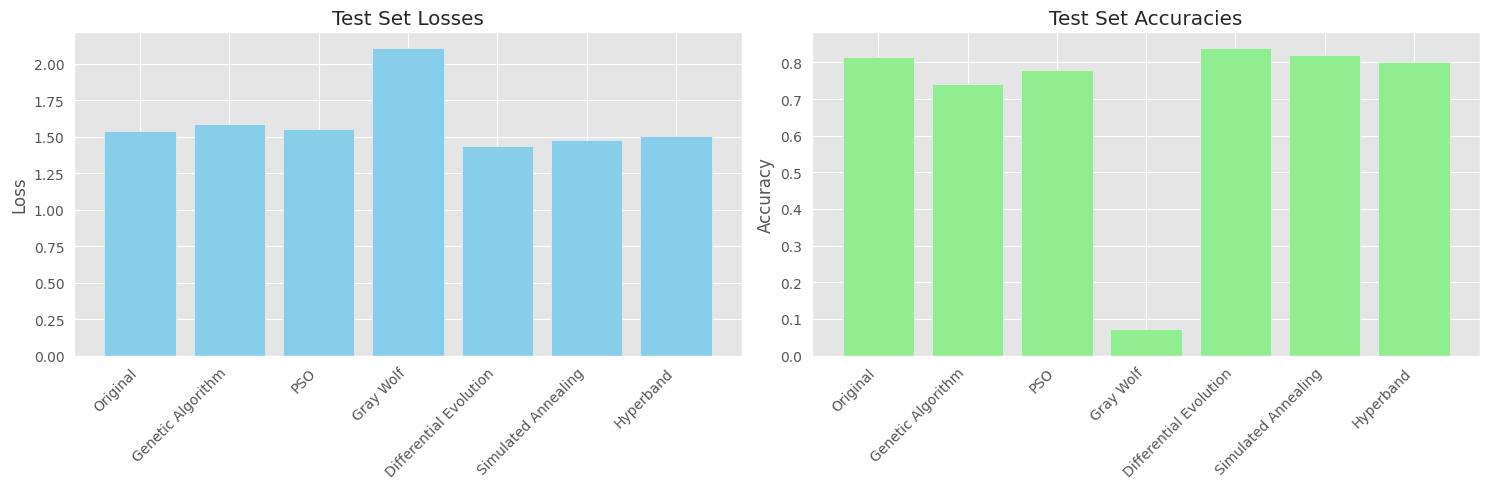

In [57]:
# Plotting the bar plots for test losses and accuracies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Test Loss Plot
axes[0].bar(models, test_losses, color='skyblue')
axes[0].set_title('Test Set Losses')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(range(len(models)))  # Set x-ticks
axes[0].set_xticklabels(models, rotation=45, ha='right')

# Test Accuracy Plot
axes[1].bar(models, test_accuracies, color='lightgreen')
axes[1].set_title('Test Set Accuracies')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(range(len(models)))  # Set x-ticks
axes[1].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Inference with New Text

In [42]:
# Specify the overall best hyperparameters
best_hyperparameters_dict = {
    "embed_dim": 18,
    "num_heads": 1,
    "ff_dim": 46,
    "num_experts": 3,
    "dropout_rate": 0.0834201189,
    "learning_rate": 0.00682405128
}

with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters_dict, f, indent=4)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 18)           868968    
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_2 (Trans  (32, 500, 18)             6657      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (32, 18)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (32, 18)                  0   

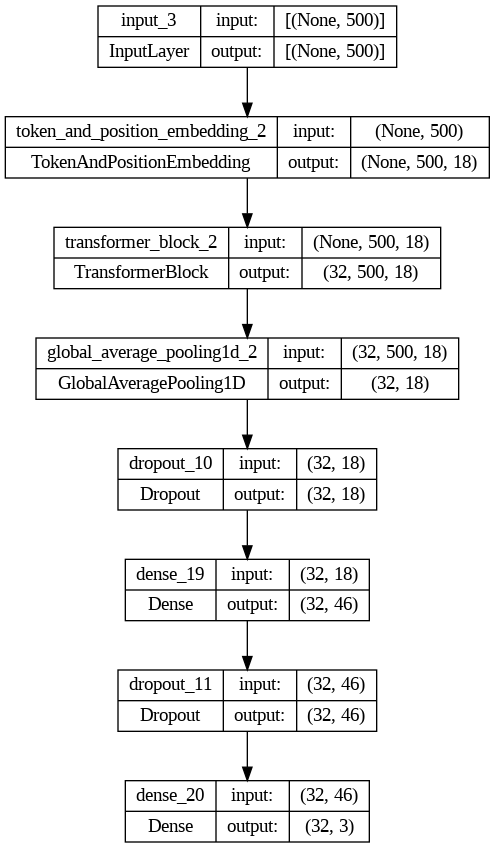

In [43]:
# Rebuild the model with the best hyperparameters
best_model = build_switch_transformer(**best_hyperparameters_dict)

# Compile the model
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters_dict["learning_rate"]),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

# Summarize and plot model
best_model.summary()
tf.keras.utils.plot_model(best_model, to_file='best_model.png', show_shapes=True)

In [44]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.tf',
                                       save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=1e-10,
        min_delta=0.01,
        verbose=1
    )
]

In [45]:
# Train the model
history_best = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/10
1243/1243 [==============================] - 410s 325ms/step - loss: 1.9493 - accuracy: 0.5860 - val_loss: 1.7470 - val_accuracy: 0.6694 - lr: 0.0068
Epoch 2/10
1243/1243 [==============================] - 314s 253ms/step - loss: 1.7147 - accuracy: 0.7556 - val_loss: 1.5381 - val_accuracy: 0.8137 - lr: 0.0068
Epoch 3/10
1243/1243 [==============================] - ETA: 0s - loss: 1.5628 - accuracy: 0.8085
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0013648102991282941.
1243/1243 [==============================] - 308s 247ms/step - loss: 1.5628 - accuracy: 0.8085 - val_loss: 1.5378 - val_accuracy: 0.7862 - lr: 0.0068
Epoch 4/10
1243/1243 [==============================] - 303s 244ms/step - loss: 1.3276 - accuracy: 0.8868 - val_loss: 1.4947 - val_accuracy: 0.8257 - lr: 0.0014
Epoch 5/10
1243/1243 [==============================] - ETA: 0s - loss: 1.2725 - accuracy: 0.9044
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00027296205516904595.
1243/1243 [=======

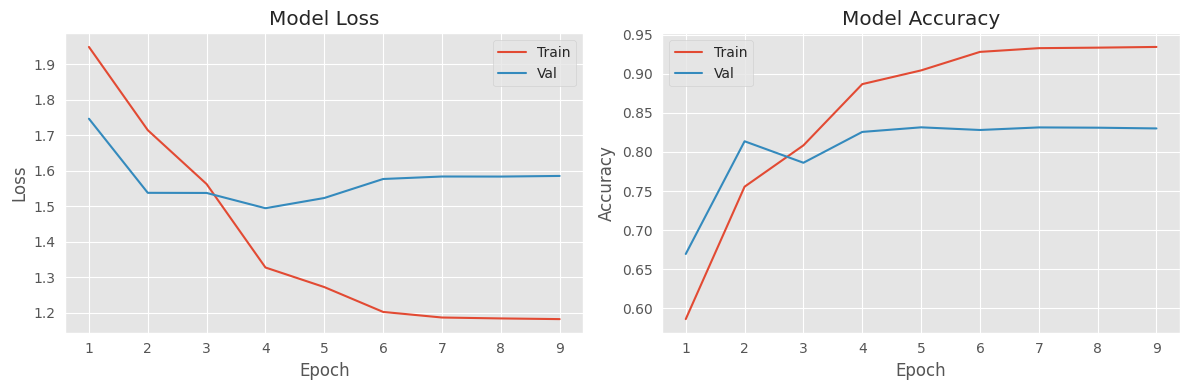

In [46]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))
epochs_range = range(1, len(history_best.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_best.history['loss'])
plt.plot(epochs_range, history_best.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper right')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_best.history['accuracy'])
plt.plot(epochs_range, history_best.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [47]:
# Load the best saved model
best_model.load_weights('best_model.tf')

# Evaluate the best model on the test set
best_test_loss_overall, best_test_accuracy_overall = best_model.evaluate(test_dataset)

print(f"Best Model Test Loss: {best_test_loss_overall}")
print(f"Best Model Test Accuracy: {best_test_accuracy_overall}")

266/266 [==============================] - 19s 72ms/step - loss: 1.4811 - accuracy: 0.8239
Best Model Test Loss: 1.4810845851898193
Best Model Test Accuracy: 0.8238956928253174


In [48]:
# Save the retrained model
best_model.save('best_retrained_model.tf')

In [60]:
# Assign the best trained model for inferencing
inference_model = tf.keras.models.load_model('best_retrained_model.tf')

# Get model summary
inference_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 18)           868968    
 ng_2 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_2 (Trans  (32, 500, 18)             6657      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (32, 18)                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_10 (Dropout)        (32, 18)                  0   

In [65]:
# Create a batch of new reviews
batch_texts = [
    "This product is so terrifyingly addictive! The price was so low it made me lose my mind!",
    "I absolutely love this! It exceeded all my expectations, and I highly recommend it.",
    "Not what I expected, and it arrived damaged. Very disappointed.",
    "Decent quality for the price, but it took too long to arrive.",
    "An excellent choice for anyone looking for high quality at a reasonable price.",
    "Terrible experience, the product broke within a week of using it.",
    "Fantastic! Works exactly as described and is incredibly easy to use.",
    "Meh, it was okay but nothing to write home about. Wouldn't buy again.",
    "Best purchase I've made this year, completely worth the money.",
    "The size was not as expected, smaller than anticipated.",
    "Wonderfully crafted and arrived earlier than expected.",
    "One star - the product stopped working after two days.",
    "Five stars! A must-have item, I'm so happy with my purchase.",
    "Mediocre performance, I expected something better for the price.",
    "Color was different from what was shown on the website.",
    "Outstanding quality, it's evident that a lot of thought went into this product.",
    "Received the wrong item, and the return process was a nightmare.",
    "A lifesaver! It has made my daily routine so much easier.",
    "Sadly, it didn't meet my expectations, the features are lacking.",
    "Highly durable and reliable, I've been using it for months without issues.",
    "Way overpriced for what you get. There are better options out there.",
    "A decent product but the customer service was unhelpful.",
    "Installation was a breeze, and it's been working flawlessly since.",
    "Poorly made, started falling apart almost immediately.",
    "A game changer! It has drastically improved my workflow.",
    "It's just alright, not as great as the reviews made it seem.",
    "Perfect for my needs, compact and efficient.",
    "Delivery was quick, but the packaging was overdone and wasteful.",
    "Incredibly user-friendly and intuitive, even for beginners.",
    "The product is okay, but the shipping cost was outrageous.",
    "Exceeded my expectations in terms of durability and functionality.",
    "Looks good but is quite flimsy and feels cheaply made."
]

In [66]:
# Vectorize batch of text data
vectorized_texts = vectorize_layer(batch_texts)
print(f"Text shape: {vectorized_texts.shape}")

Text shape: (32, 500)


In [67]:
# Make predictions with the model
predictions = inference_model.predict(vectorized_texts)

# Define a mapping from class indices to sentiment names
index_to_sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Convert predictions to class labels
predicted_sentiments = [index_to_sentiment[np.argmax(pred)] for pred in predictions]

# Print the predicted sentiment for each review
for review, sentiment in zip(batch_texts, predicted_sentiments):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

1/1 [==============================] - 0s 92ms/step
Review: This product is so terrifyingly addictive! The price was so low it made me lose my mind!
Predicted Sentiment: positive

Review: I absolutely love this! It exceeded all my expectations, and I highly recommend it.
Predicted Sentiment: positive

Review: Not what I expected, and it arrived damaged. Very disappointed.
Predicted Sentiment: negative

Review: Decent quality for the price, but it took too long to arrive.
Predicted Sentiment: neutral

Review: An excellent choice for anyone looking for high quality at a reasonable price.
Predicted Sentiment: positive

Review: Terrible experience, the product broke within a week of using it.
Predicted Sentiment: negative

Review: Fantastic! Works exactly as described and is incredibly easy to use.
Predicted Sentiment: positive

Review: Meh, it was okay but nothing to write home about. Wouldn't buy again.
Predicted Sentiment: neutral

Review: Best purchase I've made this year, completely w